# Machine Learning - Project - Deep Learning VS Trees


In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [reposit
ory](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [3]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('/kaggle/input/adopted/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [48]:
dataset.head()

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0


In [5]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [6]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans
    '''
    # TODO
    return df.dropna()


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical
    if it has <= n unique values
    '''
    # TODO
    for column in df.columns:
        if column in ignore:
            continue

        if df[column].nunique() <= n:
            df[column] = df[column].astype('category')

    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less',
                        ignore=[target_column]):
    '''

    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    for column in df.columns:
        if column in ignore:
            continue
        if df[column].dtype == condition:
            if direction == 'less':
                if df[column].nunique() < n:
                    df = df.drop(column, axis=1)
            elif direction == 'more':
                if df[column].nunique() > n:
                    df = df.drop(column, axis=1)
    return df

In [54]:
df = dataset
df = remove_nans(df)

df = numerical_to_categorical(df, n=3, ignore=[target_column])

df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])

df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])

assert not df.isna().any().any(), 'There are still nans in the dataframe'


/tmp/ipykernel_32/248706895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column] = df[column].astype('category')
/tmp/ipykernel_32/248706895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column] = df[column].astype('category')
/tmp/ipykernel_32/248706895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [8]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y
Y = df[target_column]
X = df.drop(target_column, axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [9]:
Y

2         1.0
6         1.0
7         1.0
8         1.0
12        2.0
         ... 
328127    2.0
328128    1.0
328129    1.0
328130    2.0
328131    2.0
Name: Sex_of_Driver, Length: 96326, dtype: category
Categories (3, object): ['1.0', '2.0', '3.0']

## Task 1: Create a GradientBoostingClassifier

In [10]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set

gradientBoostingClassifier = GradientBoostingClassifier()
gradientBoostingClassifier.fit(train_X, train_y)
y_pred = gradientBoostingClassifier.predict(test_X)

In [11]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics#
accuracy , precision , recall = accuracy_score(test_y, y_pred), precision_score(test_y, y_pred,average = "micro"), recall_score(test_y, y_pred,average = "micro")
print(accuracy, precision, recall)

0.7965846569085435 0.7965846569085435 0.7965846569085435


In [12]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO
    accuracyList = []
    precisionList = []
    recallList = []
    for tree in trees_amount:
        gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=tree)
        gradientBoostingClassifier.fit(train_X, train_y)
        y_pred = gradientBoostingClassifier.predict(test_X)
        accuracy , precision , recall = accuracy_score(test_y, y_pred), precision_score(test_y, y_pred,average = "micro"), recall_score(test_y, y_pred,average = "micro")
        print(accuracy, precision, recall)
        accuracyList.append(accuracy)
        precisionList.append(precision)
        recallList.append(recall)
    return accuracyList, precisionList, recallList


In [13]:
accuracyList, precisionList, recallList = trees_amount_exploration(train_X, train_y, test_X, test_y)

0.6515104328869511 0.6515104328869511 0.6515104328869511
0.7785217481573757 0.7785217481573757 0.7785217481573757
0.7902003529533894 0.7902003529533894 0.7902003529533894
0.7965846569085435 0.7965846569085435 0.7965846569085435


In [14]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
    accuracyList = []
    precisionList = []
    recallList = []
    for rate in learning_rates:
        gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=rate)
        gradientBoostingClassifier.fit(train_X, train_y)
        y_pred = gradientBoostingClassifier.predict(test_X)
        accuracy , precision , recall = accuracy_score(test_y, y_pred), precision_score(test_y, y_pred,average = "micro"), recall_score(test_y, y_pred,average = "micro")
        print(accuracy, precision, recall)
        accuracyList.append(accuracy)
        precisionList.append(precision)
        recallList.append(recall)
    return accuracyList, precisionList, recallList

In [15]:
accuracyList_learning_rate_exploration, precisionList_learning_rate_exploration, recallList_learning_rate_exploration = learning_rate_exploration(train_X, train_y, test_X, test_y)

0.7965846569085435 0.7965846569085435 0.7965846569085435
0.8006851448146994 0.8006851448146994 0.8006851448146994
0.8015156233779716 0.8015156233779716 0.8015156233779716
0.7849060521125298 0.7849060521125298 0.7849060521125298
0.7976746600228382 0.7976746600228382 0.7976746600228382


In [41]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    # TODO
    accuracyList = []
    precisionList = []
    recallList = []
    for depth in depths:
        gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=50, max_depth=depth)
        gradientBoostingClassifier.fit(train_X, train_y)
        y_pred = gradientBoostingClassifier.predict(test_X)
        accuracy , precision , recall = accuracy_score(test_y, y_pred), precision_score(test_y, y_pred,average = "micro"), recall_score(test_y, y_pred,average = "micro")
        print(accuracy, precision, recall)
        accuracyList.append(accuracy)
        precisionList.append(precision)
        recallList.append(recall)
    return accuracyList, precisionList, recallList

In [42]:
accuracyList_max_depth_exploration, precisionList_max_depth_exploration, recallList_max_depth_exploration = max_depth_exploration(train_X, train_y, test_X, test_y)

0.7512197653898058 0.7512197653898058 0.7512197653898058
0.7709955361777224 0.7709955361777224 0.7709955361777224
0.7901484480431848 0.7901484480431848 0.7901484480431848
0.805356586733105 0.805356586733105 0.805356586733105


**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [18]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # TODO plot the explained variance
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", align="center")
    plt.xticks(range(X.shape[1]), indices, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

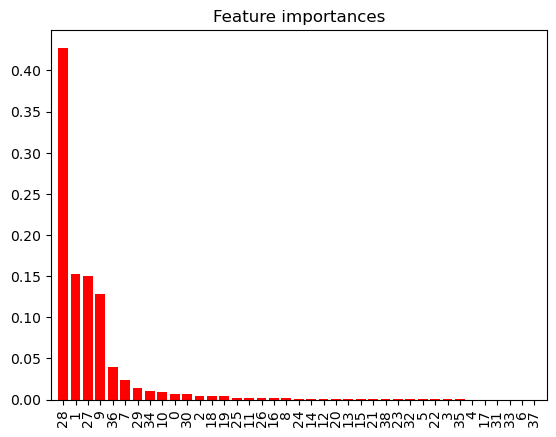

In [19]:
## TODO : display the plot
plot_explained_variance(gradientBoostingClassifier, train_X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [20]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """

    return float (correct) / total

In [21]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in dataloader:
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))
        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)

In [22]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import tqdm




def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
  # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    master_bar = trange(num_epochs)
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc = validate(val_dataloader, model, loss_function, 
                                                 device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc: {epoch_val_acc:.3f}')
            
    return train_losses, val_losses, train_accs, val_accs


In [23]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 
import seaborn as sns
import pandas as pd

def plot(train_metrics, validation_metrics, x, x_label, y_label, legend_names):
    df = pd.DataFrame(zip(x, train_metrics, [legend_names[0]] * len(train_metrics)), columns=[x_label, y_label, "type"])
    df = pd.concat([df, pd.DataFrame(zip(x, validation_metrics, [legend_names[1]] * len(train_metrics)), columns=[x_label, y_label, "type" ])])
    ax = sns.pointplot(data=df, x=x_label, y=y_label, hue='type', linestyles=['--', '--'])
    plt.plot()

### Convert a pandas dataframe to a PyTorch dataset

In [24]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        if type(df_x) != np.ndarray:
            self.x = df_x.to_numpy()
        else:
            self.x = df_x
            
        if type(df_y) != np.ndarray:
            self.y = df_y.to_numpy()
        else:
            self.y = df_y
            
        self.mean = mean
        self.std = std
        self.normalise = normalise
    
    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.x)
    
    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        return self.x[index], self.y[index]

In [25]:
# def Convert categorical values to numerical
def convert_categorical_to_numerical(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype('category')
            df[column] = df[column].cat.codes
    return df

In [26]:
from sklearn.preprocessing import LabelEncoder


# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical variable
Y = label_encoder.fit_transform(Y)

# Convert the numerical variable to the desired dtype
Y = Y.astype('int64')

In [27]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer
X = convert_categorical_to_numerical(X)


X_train , X_test, y_train, y_test =train_test_split(X, Y, test_size=test_size, random_state=random_state)
mean = X_train.mean()
std = X_train.std()

print(mean)
print('=======')
print(std)
print(type(Y[0]))

Vehicle_Reference_df_res                 1.548521
Vehicle_Type                             9.449169
Vehicle_Manoeuvre                       11.983091
Vehicle_Location-Restricted_Lane         0.055463
Hit_Object_in_Carriageway                0.294705
Hit_Object_off_Carriageway               0.386777
Age_of_Driver                           40.517804
Age_Band_of_Driver                       6.918622
Engine_Capacity_(CC)                  1802.278238
Age_of_Vehicle                           8.047431
Location_Easting_OSGR               449771.654192
Location_Northing_OSGR              293534.287231
Longitude                               -1.274029
Latitude                                52.531363
Police_Force                            20.289813
Number_of_Casualties                     1.911952
Local_Authority_(District)             249.506385
1st_Road_Number                       1087.891020
2nd_Road_Number                        672.102115
Vehicle_Reference_df                     1.613898


/tmp/ipykernel_32/3862787249.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = X_train.mean()
/tmp/ipykernel_32/3862787249.py:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std = X_train.std()


In [28]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!
train_dataset = TabularDataset(X_train, y_train, mean, std, normalise=True)
test_dataset = TabularDataset(X_test, y_test, mean, std, normalise=True)


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Logistic regression

In [29]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        outputs = self.linear(x)
        return outputs

In [30]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices

lr=0.001
input_dim, output_dim = X_train.shape[1], len(np.unique(y_train))
model = LR(input_dim, output_dim)
model.to(device)
model.train()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
## TODO train the network
from tqdm import trange
     

num_epochs = 30
train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(model = model, optimizer = optimizer, loss_function = loss_function, device = device, num_epochs =num_epochs, train_dataloader = train_dataloader, val_dataloader = val_dataloader)

  3%|▎         | 1/30 [00:01<00:46,  1.59s/it]

Train loss: 6014.20, val loss: 45.32, train acc: 0.553, val acc: 0.463


  7%|▋         | 2/30 [00:03<00:42,  1.53s/it]

Train loss: 82.66, val loss: 20.55, train acc: 0.553, val acc: 0.645


 10%|█         | 3/30 [00:04<00:40,  1.49s/it]

Train loss: 89.51, val loss: 22.35, train acc: 0.554, val acc: 0.588


 13%|█▎        | 4/30 [00:05<00:38,  1.46s/it]

Train loss: 69.14, val loss: 42.34, train acc: 0.558, val acc: 0.393


 17%|█▋        | 5/30 [00:07<00:36,  1.47s/it]

Train loss: 71.74, val loss: 48.81, train acc: 0.558, val acc: 0.651


 20%|██        | 6/30 [00:08<00:35,  1.48s/it]

Train loss: 62.67, val loss: 23.97, train acc: 0.557, val acc: 0.563


 23%|██▎       | 7/30 [00:10<00:33,  1.47s/it]

Train loss: 62.92, val loss: 150.61, train acc: 0.559, val acc: 0.355


 27%|██▋       | 8/30 [00:11<00:32,  1.48s/it]

Train loss: 64.20, val loss: 22.00, train acc: 0.562, val acc: 0.646


 30%|███       | 9/30 [00:13<00:31,  1.48s/it]

Train loss: 64.81, val loss: 17.21, train acc: 0.560, val acc: 0.497


 33%|███▎      | 10/30 [00:14<00:29,  1.47s/it]

Train loss: 64.61, val loss: 18.78, train acc: 0.558, val acc: 0.636


 37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

Train loss: 67.36, val loss: 106.25, train acc: 0.558, val acc: 0.652


 40%|████      | 12/30 [00:17<00:26,  1.47s/it]

Train loss: 58.54, val loss: 140.27, train acc: 0.555, val acc: 0.651


 43%|████▎     | 13/30 [00:19<00:25,  1.48s/it]

Train loss: 60.99, val loss: 135.38, train acc: 0.559, val acc: 0.652


 47%|████▋     | 14/30 [00:20<00:23,  1.48s/it]

Train loss: 81.10, val loss: 59.90, train acc: 0.560, val acc: 0.385


 50%|█████     | 15/30 [00:22<00:22,  1.52s/it]

Train loss: 73.57, val loss: 74.65, train acc: 0.557, val acc: 0.652


 53%|█████▎    | 16/30 [00:23<00:21,  1.52s/it]

Train loss: 55.23, val loss: 39.82, train acc: 0.560, val acc: 0.651


 57%|█████▋    | 17/30 [00:25<00:19,  1.50s/it]

Train loss: 66.19, val loss: 167.45, train acc: 0.561, val acc: 0.349


 60%|██████    | 18/30 [00:26<00:17,  1.49s/it]

Train loss: 67.67, val loss: 35.29, train acc: 0.559, val acc: 0.651


 63%|██████▎   | 19/30 [00:28<00:16,  1.48s/it]

Train loss: 78.92, val loss: 121.16, train acc: 0.559, val acc: 0.363


 67%|██████▋   | 20/30 [00:29<00:14,  1.50s/it]

Train loss: 69.24, val loss: 10.81, train acc: 0.560, val acc: 0.624


 70%|███████   | 21/30 [00:31<00:13,  1.48s/it]

Train loss: 41.91, val loss: 31.98, train acc: 0.558, val acc: 0.651


 73%|███████▎  | 22/30 [00:32<00:11,  1.47s/it]

Train loss: 67.19, val loss: 130.49, train acc: 0.559, val acc: 0.356


 77%|███████▋  | 23/30 [00:34<00:10,  1.47s/it]

Train loss: 69.13, val loss: 83.25, train acc: 0.556, val acc: 0.652


 80%|████████  | 24/30 [00:35<00:08,  1.47s/it]

Train loss: 79.59, val loss: 178.60, train acc: 0.560, val acc: 0.652


 83%|████████▎ | 25/30 [00:37<00:07,  1.48s/it]

Train loss: 68.31, val loss: 24.62, train acc: 0.559, val acc: 0.405


 87%|████████▋ | 26/30 [00:38<00:06,  1.51s/it]

Train loss: 57.35, val loss: 45.02, train acc: 0.563, val acc: 0.651


 90%|█████████ | 27/30 [00:40<00:04,  1.48s/it]

Train loss: 66.08, val loss: 71.12, train acc: 0.558, val acc: 0.652


 93%|█████████▎| 28/30 [00:41<00:02,  1.50s/it]

Train loss: 50.04, val loss: 40.08, train acc: 0.563, val acc: 0.652


 97%|█████████▋| 29/30 [00:43<00:01,  1.49s/it]

Train loss: 58.36, val loss: 65.26, train acc: 0.558, val acc: 0.375


100%|██████████| 30/30 [00:44<00:00,  1.49s/it]

Train loss: 48.39, val loss: 75.61, train acc: 0.565, val acc: 0.652


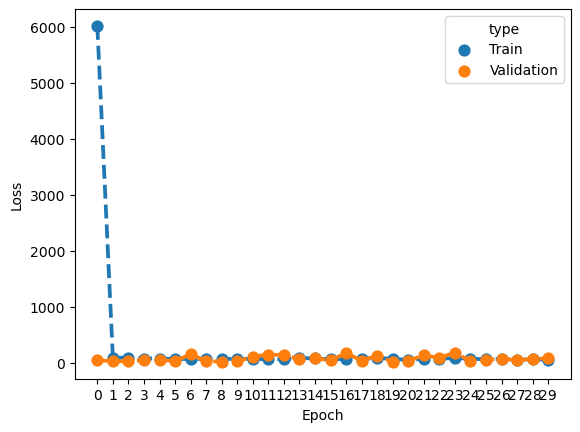

In [32]:
## todo - plot losses and accuracies
plot(train_losses_lr, val_losses_lr, range(num_epochs), 'Epoch', 'Loss' ,['Train', 'Validation'])


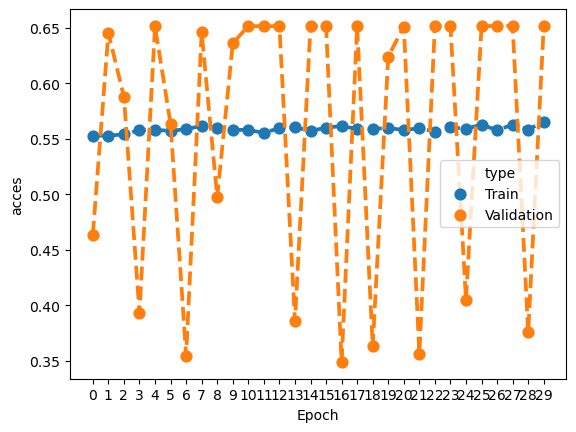

In [33]:
plot(train_accs_lr, val_accs_lr, range(num_epochs), 'Epoch', 'acces', ['Train', 'Validation'])



## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [34]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim),
        )
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO
        # run the data through the network
        x = x.to(self.network[0].weight.dtype)
        outputs = self.network(x)
        return outputs

In [35]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001
model = TabularNetwork(input_dim, output_dim)
model.to(device)
model.train()


TabularNetwork(
  (network): Sequential(
    (0): Linear(in_features=39, out_features=19, bias=True)
    (1): ReLU()
    (2): Linear(in_features=19, out_features=3, bias=True)
  )
)

In [36]:
## TODO : Train model
num_epochs = 50
train_losses_mlp , val_losses_mlp, train_accs_mlp, val_accs_mlp = run_training(model = model, optimizer = optimizer, loss_function = loss_function, device = device, num_epochs =num_epochs, train_dataloader = train_dataloader, val_dataloader = val_dataloader)

  2%|▏         | 1/50 [00:01<01:17,  1.58s/it]

Train loss: 12858.03, val loss: 12894.95, train acc: 0.014, val acc: 0.016


  4%|▍         | 2/50 [00:03<01:14,  1.56s/it]

Train loss: 12850.73, val loss: 12876.78, train acc: 0.014, val acc: 0.016


  6%|▌         | 3/50 [00:04<01:12,  1.55s/it]

Train loss: 12861.14, val loss: 12893.85, train acc: 0.014, val acc: 0.016


  8%|▊         | 4/50 [00:06<01:10,  1.53s/it]

Train loss: 12870.73, val loss: 12910.25, train acc: 0.014, val acc: 0.016


 10%|█         | 5/50 [00:07<01:12,  1.60s/it]

Train loss: 12892.67, val loss: 12896.00, train acc: 0.014, val acc: 0.016


 12%|█▏        | 6/50 [00:09<01:11,  1.62s/it]

Train loss: 12865.73, val loss: 12906.02, train acc: 0.014, val acc: 0.016


 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it]

Train loss: 12888.04, val loss: 12901.59, train acc: 0.014, val acc: 0.016


 16%|█▌        | 8/50 [00:12<01:06,  1.58s/it]

Train loss: 12911.35, val loss: 12895.33, train acc: 0.014, val acc: 0.016


 18%|█▊        | 9/50 [00:14<01:04,  1.57s/it]

Train loss: 12859.48, val loss: 12894.21, train acc: 0.014, val acc: 0.016


 20%|██        | 10/50 [00:15<01:01,  1.55s/it]

Train loss: 12861.11, val loss: 12891.17, train acc: 0.014, val acc: 0.016


 22%|██▏       | 11/50 [00:17<00:59,  1.52s/it]

Train loss: 12860.18, val loss: 12907.99, train acc: 0.014, val acc: 0.016


 24%|██▍       | 12/50 [00:18<00:57,  1.51s/it]

Train loss: 12882.66, val loss: 12883.57, train acc: 0.014, val acc: 0.016


 26%|██▌       | 13/50 [00:20<00:55,  1.51s/it]

Train loss: 12856.38, val loss: 12905.83, train acc: 0.014, val acc: 0.016


 28%|██▊       | 14/50 [00:21<00:54,  1.51s/it]

Train loss: 12863.87, val loss: 12890.52, train acc: 0.014, val acc: 0.016


 30%|███       | 15/50 [00:23<00:53,  1.52s/it]

Train loss: 12871.51, val loss: 12894.44, train acc: 0.014, val acc: 0.016


 32%|███▏      | 16/50 [00:24<00:51,  1.51s/it]

Train loss: 12881.68, val loss: 12874.19, train acc: 0.014, val acc: 0.016


 34%|███▍      | 17/50 [00:26<00:49,  1.51s/it]

Train loss: 12883.08, val loss: 12890.55, train acc: 0.014, val acc: 0.016


 36%|███▌      | 18/50 [00:27<00:48,  1.52s/it]

Train loss: 12855.15, val loss: 12884.88, train acc: 0.014, val acc: 0.016


 38%|███▊      | 19/50 [00:29<00:47,  1.52s/it]

Train loss: 12882.84, val loss: 12891.00, train acc: 0.014, val acc: 0.016


 40%|████      | 20/50 [00:30<00:45,  1.52s/it]

Train loss: 12853.20, val loss: 12882.05, train acc: 0.014, val acc: 0.016


 42%|████▏     | 21/50 [00:32<00:44,  1.52s/it]

Train loss: 12847.43, val loss: 12891.49, train acc: 0.014, val acc: 0.016


 44%|████▍     | 22/50 [00:33<00:42,  1.51s/it]

Train loss: 12873.17, val loss: 12882.44, train acc: 0.014, val acc: 0.016


 46%|████▌     | 23/50 [00:35<00:40,  1.52s/it]

Train loss: 12866.46, val loss: 12876.19, train acc: 0.014, val acc: 0.016


 48%|████▊     | 24/50 [00:36<00:39,  1.52s/it]

Train loss: 12883.51, val loss: 12889.45, train acc: 0.014, val acc: 0.016


 50%|█████     | 25/50 [00:38<00:38,  1.52s/it]

Train loss: 12884.28, val loss: 12899.53, train acc: 0.014, val acc: 0.016


 52%|█████▏    | 26/50 [00:40<00:40,  1.68s/it]

Train loss: 12872.88, val loss: 12898.05, train acc: 0.014, val acc: 0.016


 54%|█████▍    | 27/50 [00:41<00:37,  1.64s/it]

Train loss: 12856.17, val loss: 12899.94, train acc: 0.014, val acc: 0.016


 56%|█████▌    | 28/50 [00:43<00:35,  1.61s/it]

Train loss: 12877.06, val loss: 12886.73, train acc: 0.014, val acc: 0.016


 58%|█████▊    | 29/50 [00:45<00:33,  1.58s/it]

Train loss: 12867.80, val loss: 12889.08, train acc: 0.014, val acc: 0.016


 60%|██████    | 30/50 [00:46<00:30,  1.55s/it]

Train loss: 12865.20, val loss: 12903.63, train acc: 0.014, val acc: 0.016


 62%|██████▏   | 31/50 [00:47<00:29,  1.53s/it]

Train loss: 12855.91, val loss: 12889.03, train acc: 0.014, val acc: 0.016


 64%|██████▍   | 32/50 [00:49<00:27,  1.51s/it]

Train loss: 12876.38, val loss: 12886.34, train acc: 0.014, val acc: 0.016


 66%|██████▌   | 33/50 [00:50<00:25,  1.50s/it]

Train loss: 12886.53, val loss: 12903.47, train acc: 0.014, val acc: 0.016


 68%|██████▊   | 34/50 [00:52<00:24,  1.51s/it]

Train loss: 12878.07, val loss: 12912.09, train acc: 0.014, val acc: 0.016


 70%|███████   | 35/50 [00:53<00:22,  1.50s/it]

Train loss: 12868.77, val loss: 12903.15, train acc: 0.014, val acc: 0.016


 72%|███████▏  | 36/50 [00:55<00:21,  1.50s/it]

Train loss: 12846.09, val loss: 12899.00, train acc: 0.014, val acc: 0.016


 74%|███████▍  | 37/50 [00:56<00:19,  1.51s/it]

Train loss: 12875.80, val loss: 12882.52, train acc: 0.014, val acc: 0.016


 76%|███████▌  | 38/50 [00:58<00:18,  1.50s/it]

Train loss: 12863.84, val loss: 12895.51, train acc: 0.014, val acc: 0.016


 78%|███████▊  | 39/50 [00:59<00:16,  1.52s/it]

Train loss: 12895.23, val loss: 12901.85, train acc: 0.014, val acc: 0.016


 80%|████████  | 40/50 [01:01<00:15,  1.54s/it]

Train loss: 12877.43, val loss: 12873.75, train acc: 0.014, val acc: 0.016


 82%|████████▏ | 41/50 [01:03<00:14,  1.56s/it]

Train loss: 12863.00, val loss: 12890.46, train acc: 0.014, val acc: 0.016


 84%|████████▍ | 42/50 [01:04<00:12,  1.56s/it]

Train loss: 12888.45, val loss: 12916.62, train acc: 0.014, val acc: 0.016


 86%|████████▌ | 43/50 [01:06<00:10,  1.54s/it]

Train loss: 12880.95, val loss: 12896.95, train acc: 0.014, val acc: 0.016


 88%|████████▊ | 44/50 [01:07<00:09,  1.54s/it]

Train loss: 12886.95, val loss: 12885.48, train acc: 0.014, val acc: 0.016


 90%|█████████ | 45/50 [01:09<00:07,  1.54s/it]

Train loss: 12874.30, val loss: 12909.48, train acc: 0.014, val acc: 0.016


 92%|█████████▏| 46/50 [01:10<00:06,  1.57s/it]

Train loss: 12875.33, val loss: 12895.11, train acc: 0.014, val acc: 0.016


 94%|█████████▍| 47/50 [01:12<00:04,  1.63s/it]

Train loss: 12885.02, val loss: 12893.58, train acc: 0.014, val acc: 0.016


 96%|█████████▌| 48/50 [01:14<00:03,  1.61s/it]

Train loss: 12871.18, val loss: 12881.14, train acc: 0.014, val acc: 0.016


 98%|█████████▊| 49/50 [01:15<00:01,  1.59s/it]

Train loss: 12883.06, val loss: 12898.30, train acc: 0.014, val acc: 0.016


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]

Train loss: 12846.92, val loss: 12882.62, train acc: 0.014, val acc: 0.016


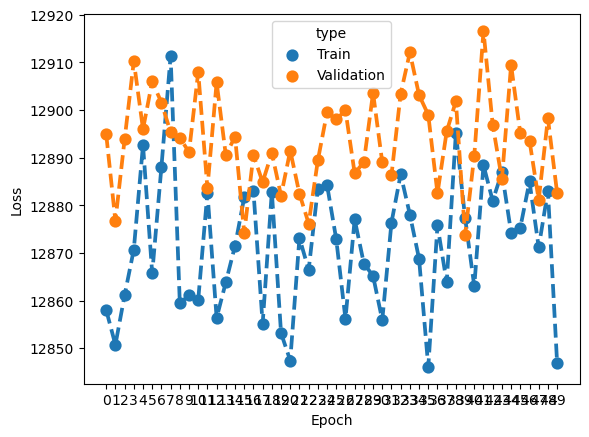

In [37]:
# TODO plot losses
plot(train_losses_mlp, val_losses_mlp, range(num_epochs), 'Epoch', 'Loss', ['Train', 'Validation'])


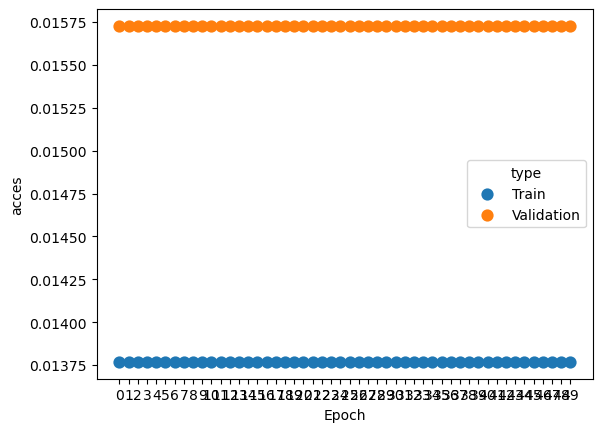

In [38]:
# TODO plot accuracies
plot(train_accs_mlp, val_accs_mlp, range(num_epochs), 'Epoch', 'acces', ['Train', 'Validation'])

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/